In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2, DenseNet201, InceptionV3, VGG16
from tensorflow.keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the disease DataFrame
df = pd.read_csv('../data-collection/dataset/skin_disease_dataset.csv')

In [3]:
# Encode labels
le_disease = LabelEncoder()
df['disease_label'] = le_disease.fit_transform(df['disease_name'])

le_effect = LabelEncoder()
df['condition_label'] = le_effect.fit_transform(df['condition'])

In [4]:
# Check class imbalance
class_counts = df['disease_name'].value_counts()
total_instances = len(df)
class_proportions = class_counts / total_instances

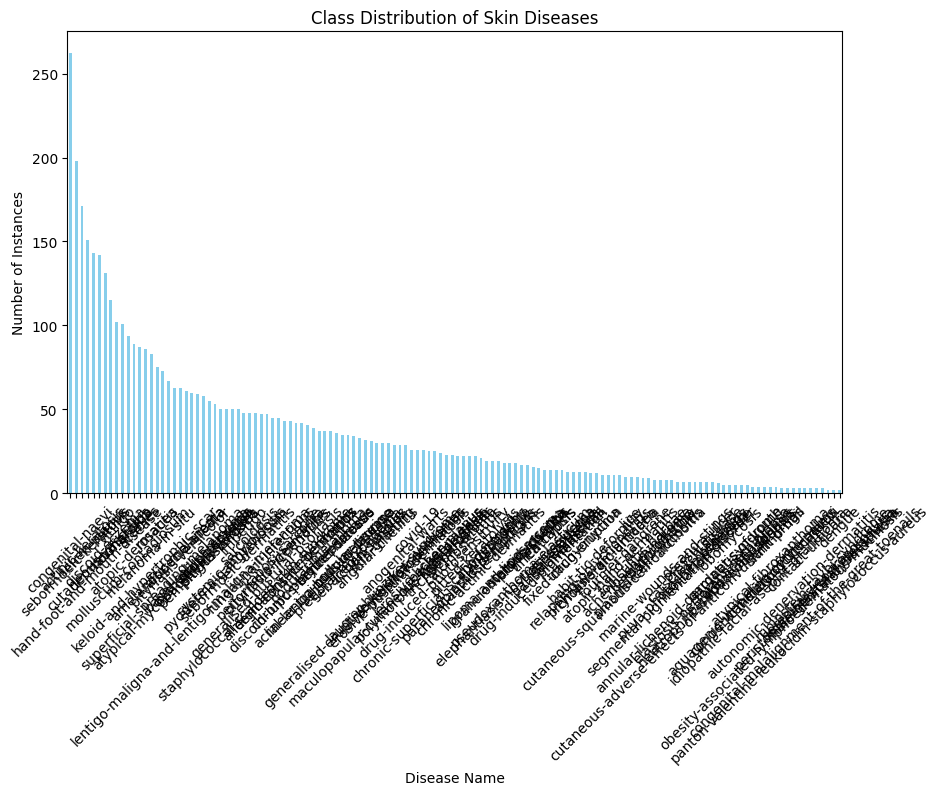

In [5]:
# Plot class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution of Skin Diseases')
plt.xlabel('Disease Name')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Balance the classes
majority_class = class_counts.idxmax()
resampled_dfs = []
for disease_name, count in class_counts.items():
    if disease_name != majority_class:
        df_minority = df[df['disease_name'] == disease_name]
        df_resampled = resample(df_minority, replace=True, n_samples=class_counts[majority_class], random_state=42)
        resampled_dfs.append(df_resampled)
df_balanced = pd.concat([df] + resampled_dfs)

In [7]:
class_counts = df_balanced['disease_name'].value_counts()
total_instances = len(df)
class_proportions = class_counts / total_instances

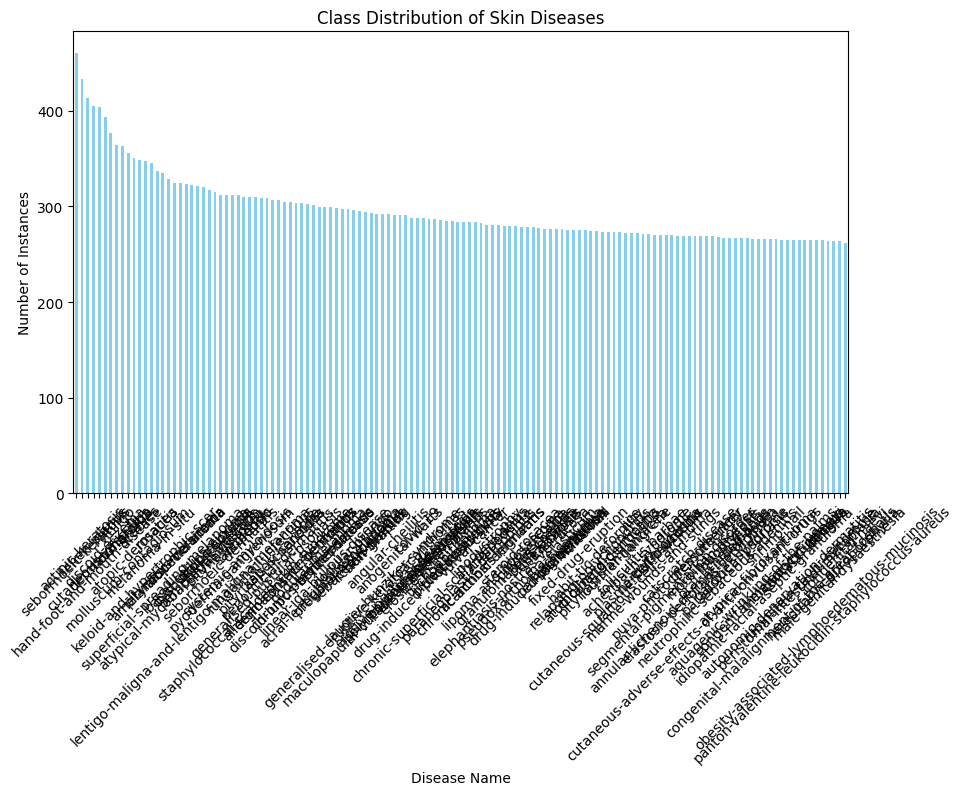

In [8]:
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution of Skin Diseases')
plt.xlabel('Disease Name')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

In [10]:
# Create training and testing datasets
X = df_balanced['image_path']
y = df_balanced['disease_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
base_model1 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model2 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model4 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base models
base_model1.trainable = False
base_model2.trainable = False
base_model3.trainable = False
base_model4.trainable = False

In [12]:
inputs = Input(shape=(224, 224, 3))

In [13]:
# Get output tensors from base models
x1 = base_model1(inputs)
x2 = base_model2(inputs)
x3 = base_model3(inputs)
x4 = base_model4(inputs)

In [14]:
# Global average pooling for each base model output
x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)
x3 = GlobalAveragePooling2D()(x3)
x4 = GlobalAveragePooling2D()(x4)

In [15]:
# Concatenate the outputs
x = Concatenate()([x1, x2, x3, x4])

In [16]:
# Add output layer
outputs = Dense(len(set(y_train)), activation='softmax')(x)

In [17]:
# Create the ensemble model
model = Model(inputs=inputs, outputs=outputs)

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 5, 5, 1536)  54336736    ['input_5[0][0]']                
 l)                                                                                               
                                                                                                  
 densenet201 (Functional)       (None, 7, 7, 1920)   18321984    ['input_5[0][0]']                
                                                                                              

In [20]:
# Train the model
history = model.fit(datagen.flow_from_dataframe(dataframe=df_balanced, x_col='image_path', y_col='disease_name',
                                                target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training'),
                    steps_per_epoch=len(X_train) // 32, epochs=15)

Found 31728 validated image filenames belonging to 134 classes.
Epoch 1/15
991/991 [==============================] - 650s 599ms/step - loss: 1.5770 - accuracy: 0.6413 - precision: 0.8649 - recall: 0.5341
Epoch 2/15
991/991 [==============================] - 526s 530ms/step - loss: 0.5778 - accuracy: 0.8468 - precision: 0.9183 - recall: 0.7969
Epoch 3/15
991/991 [==============================] - 633s 638ms/step - loss: 0.4180 - accuracy: 0.8838 - precision: 0.9277 - recall: 0.8535
Epoch 4/15
991/991 [==============================] - 759s 765ms/step - loss: 0.3616 - accuracy: 0.9007 - precision: 0.9322 - recall: 0.8803
Epoch 5/15
991/991 [==============================] - 643s 648ms/step - loss: 0.3264 - accuracy: 0.9105 - precision: 0.9350 - recall: 0.8960
Epoch 6/15
991/991 [==============================] - 663s 669ms/step - loss: 0.2954 - accuracy: 0.9186 - precision: 0.9372 - recall: 0.9084
Epoch 7/15
991/991 [==============================] - 574s 578ms/step - loss: 0.2733 - acc

In [21]:
valid_gen = datagen.flow_from_dataframe(
    dataframe=df_balanced,
    x_col='image_path',
    y_col='disease_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 7931 validated image filenames belonging to 134 classes.


In [22]:
evaluation = model.evaluate(valid_gen)

# Print the evaluation results
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])
print("Validation Precision", evaluation[2])
print("Validation Recall:", evaluation[3])

248/248 [==============================] - 139s 535ms/step - loss: 16.6821 - accuracy: 0.3529 - precision: 0.3735 - recall: 0.3496
Validation Loss: 16.68207550048828
Validation Accuracy: 0.35291892290115356
Validation Precision 0.3734680116176605
Validation Recall: 0.3496406376361847


In [23]:
# Save the model
model.save('best_model.h5')